--- First 5 Rows ---
   UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Target Failure Type  
0                    1551         42.8                0       0   No Failure  
1                    1408         46.3                3       0   No Failure  
2                    1498         49.4                5       0   No Failure  
3                    1433         39.5                7       0   No Failure  
4                    1408         40.0                9       0   No Failure  


--- Data Info (Types & Nulls) ---
<class 'pandas.core.frame.DataFrame'

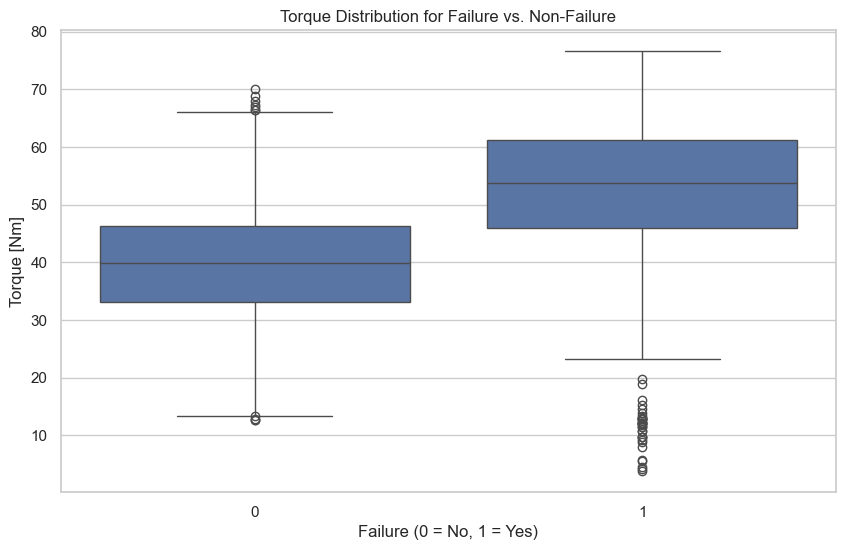

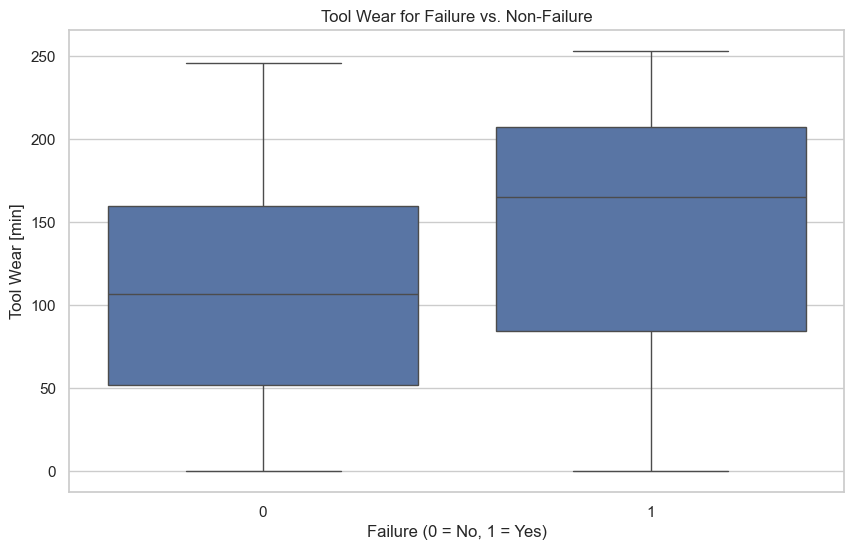

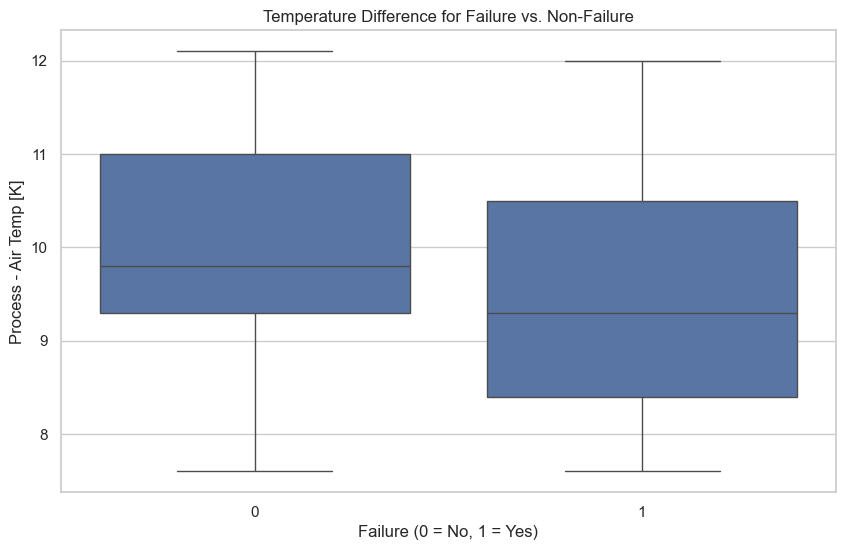

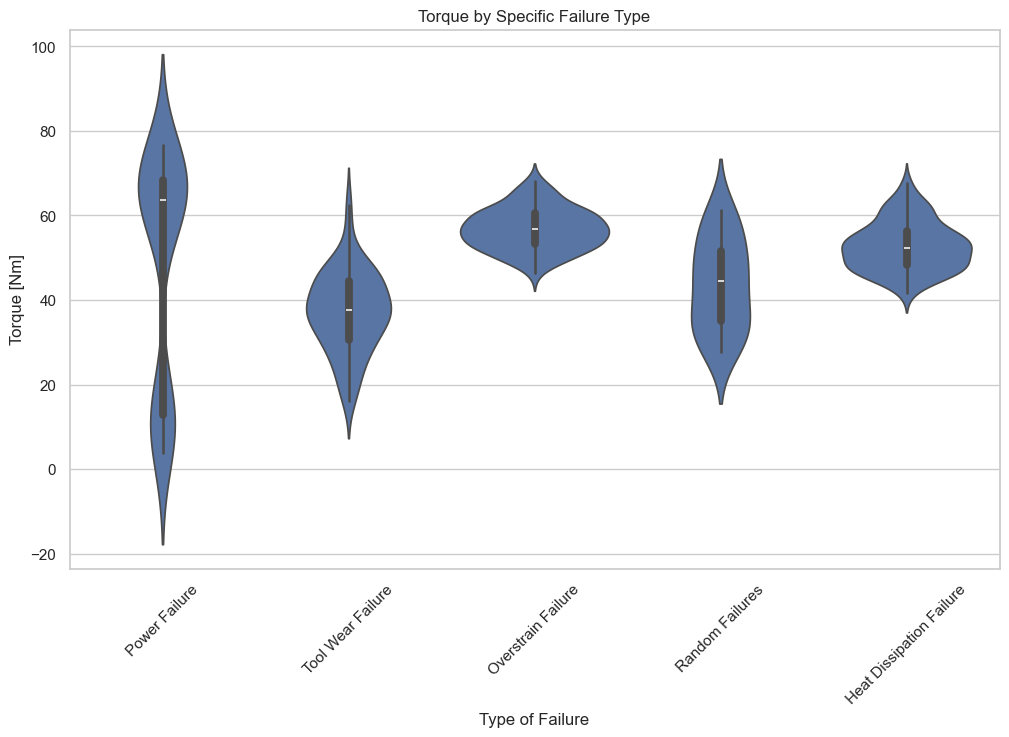

Engineered features 'power' and 'tool_strain' added.
Original training data shape: (8000, 10)
Original training failures (y=1): 271
Resampled training data shape: (15458, 10)
Resampled training failures (y=1): 7729

Data is now pre-processed, balanced, and scaled.
We are ready to build a model!
Training the model...
Model training complete.

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1932
           1       0.68      0.81      0.74        68

    accuracy                           0.98      2000
   macro avg       0.84      0.90      0.86      2000
weighted avg       0.98      0.98      0.98      2000


--- Confusion Matrix ---


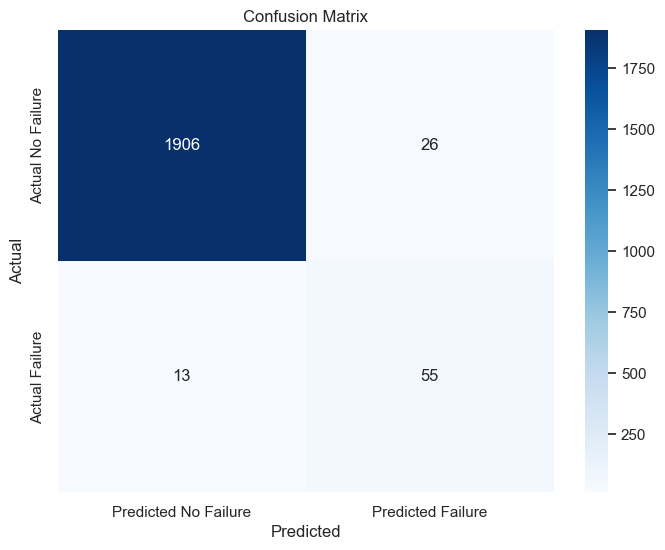


--- Model's Feature Importance ---
                   Feature  Importance
2   Rotational speed [rpm]    0.193358
3              Torque [Nm]    0.177987
6                    power    0.169168
4          Tool wear [min]    0.127554
7              tool_strain    0.114428
5                temp_diff    0.083111
0      Air temperature [K]    0.047178
8                   Type_L    0.038544
1  Process temperature [K]    0.028862
9                   Type_M    0.019810


C:\Users\human\AppData\Local\Temp\ipykernel_21048\1551593719.py:175: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance_df, x='Importance', y='Feature', palette='viridis')


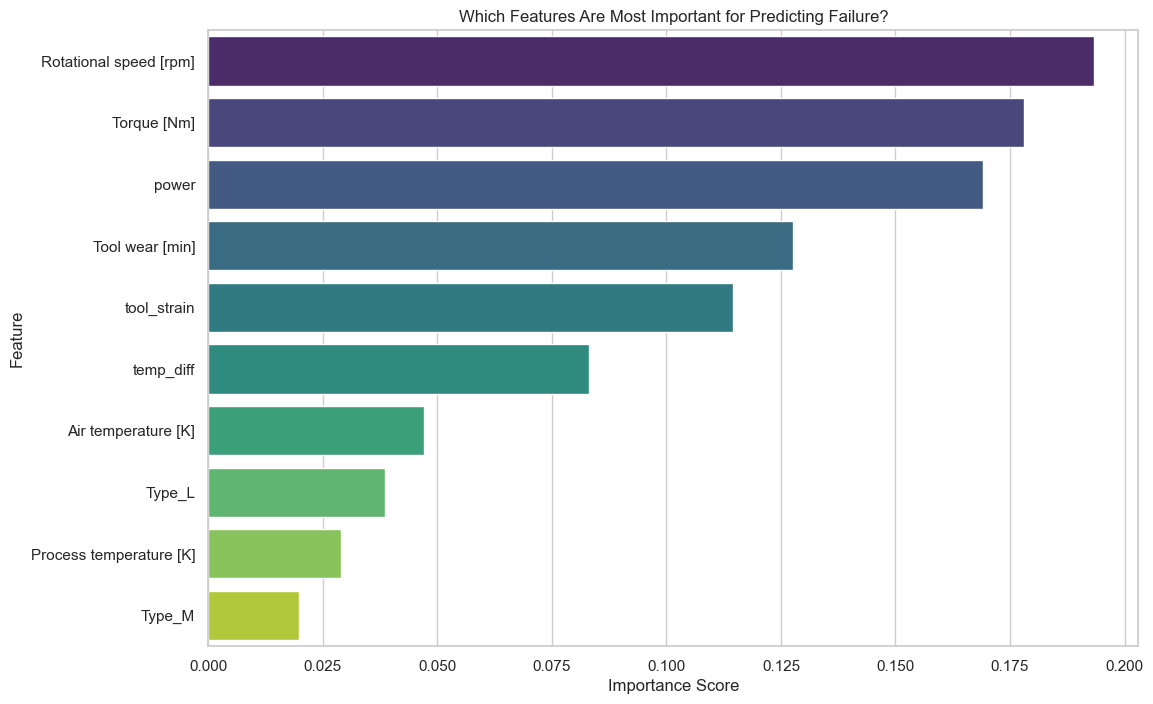

In [11]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


sns.set_theme(style="whitegrid")


try:
    df = pd.read_csv("predictive_maintenance.csv")
except FileNotFoundError:
    print("Error: 'predictive_maintenance.csv' not found.")
    print("Please make sure the file is in the same directory as your notebook.")
    
print("--- First 5 Rows ---")
print(df.head())
print("\n")


print("--- Data Info (Types & Nulls) ---")
df.info()
print("\n")


print("--- Descriptive Statistics ---")
print(df.describe())
print("\n")


print("--- Failure Count (Target Variable) ---")
print(df['Target'].value_counts())
print("\n")


plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Target', y='Torque [Nm]')
plt.title('Torque Distribution for Failure vs. Non-Failure')
plt.xlabel('Failure (0 = No, 1 = Yes)')
plt.ylabel('Torque [Nm]')
plt.show()


plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Target', y='Tool wear [min]')
plt.title('Tool Wear for Failure vs. Non-Failure')
plt.xlabel('Failure (0 = No, 1 = Yes)')
plt.ylabel('Tool Wear [min]')
plt.show()


df['temp_diff'] = df['Process temperature [K]'] - df['Air temperature [K]']


plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Target', y='temp_diff')
plt.title('Temperature Difference for Failure vs. Non-Failure')
plt.xlabel('Failure (0 = No, 1 = Yes)')
plt.ylabel('Process - Air Temp [K]')
plt.show()


failure_df = df[df['Failure Type'] != 'No Failure']


plt.figure(figsize=(12, 7))
sns.violinplot(data=failure_df, x='Failure Type', y='Torque [Nm]')
plt.title('Torque by Specific Failure Type')
plt.xlabel('Type of Failure')
plt.ylabel('Torque [Nm]')
plt.xticks(rotation=45) 
plt.show()

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE


df['power'] = df['Torque [Nm]'] * df['Rotational speed [rpm]']
df['tool_strain'] = df['Torque [Nm]'] * df['Tool wear [min]']
print("Engineered features 'power' and 'tool_strain' added.")


df = pd.get_dummies(df, columns=['Type'], drop_first=True) 


features_to_use = [
    'Air temperature [K]', 
    'Process temperature [K]', 
    'Rotational speed [rpm]',
    'Torque [Nm]', 
    'Tool wear [min]',
    'temp_diff',  
    'power',      
    'tool_strain',
    'Type_L',     
    'Type_M'      
]

X = df[features_to_use]
y = df['Target'] 


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


smote = SMOTE(random_state=42)
print(f"Original training data shape: {X_train.shape}")
print(f"Original training failures (y=1): {sum(y_train == 1)}")

X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"Resampled training data shape: {X_train_resampled.shape}")
print(f"Resampled training failures (y=1): {sum(y_train_resampled == 1)}")



scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test) 

print("\nData is now pre-processed, balanced, and scaled.")
print("We are ready to build a model!")


from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix


model = RandomForestClassifier(random_state=42, n_estimators=100)


print("Training the model...")

model.fit(X_train_scaled, y_train_resampled)
print("Model training complete.")


y_pred = model.predict(X_test_scaled)

print("\n--- Classification Report ---")

print(classification_report(y_test, y_pred))


print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred)


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted No Failure', 'Predicted Failure'],
            yticklabels=['Actual No Failure', 'Actual Failure'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

importances = model.feature_importances_


feature_importance_df = pd.DataFrame({
    'Feature': features_to_use,  
    'Importance': importances
})


feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)


print("\n--- Model's Feature Importance ---")
print(feature_importance_df)

plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance_df, x='Importance', y='Feature', palette='viridis')
plt.title('Which Features Are Most Important for Predicting Failure?')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()